In [1]:
import sys, types
sys.path.append('./../tensormorph')
import config
import tensormorph
from radial_basis import GaussianPool

import torch
from torch import sigmoid
import numpy as np
import matplotlib.pyplot as plt

args = types.SimpleNamespace()
args.data = 'chamorro/chamorro_um'
args.features = 'hayes_features'
args.reduplication = False
args.global_config = '../global_config.yaml'
tensormorph.init(args)
#tensormorph.init(dataset = 'chamorro_um') #, features = 'one_hot')
decoder = config.decoder


train: 145| val: 1| test: 49
segments: ['a', 'b', 'c', 'd', 'dz', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'ts', 'u', 'z', 'ŋ', 'ʔ']
vowels: ['i', 'e', 'a', 'o', 'u']
max_len: 20
['ε', '⋊', '⋉', 'a', 'o', 'e', 'u', 'i', 'ŋ', 'r', 'n', 'm', 'l', 'ʔ', 'c', 'k', 'g', 'z', 't', 's', 'p', 'f', 'd', 'b', 'dz', 'ts', 'h'] 27
['a', 'o', 'e', 'u', 'i']
['sym', 'begin/end', 'C/V', 'syllabic', 'consonantal', 'sonorant', 'continuant', 'delayed.release', 'approximant', 'trill', 'nasal', 'voice', 'spread.gl', 'constr.gl', 'LABIAL', 'round', 'labiodental', 'CORONAL', 'anterior', 'distributed', 'strident', 'lateral', 'DORSAL', 'high', 'low', 'front', 'back', 'tense']
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  

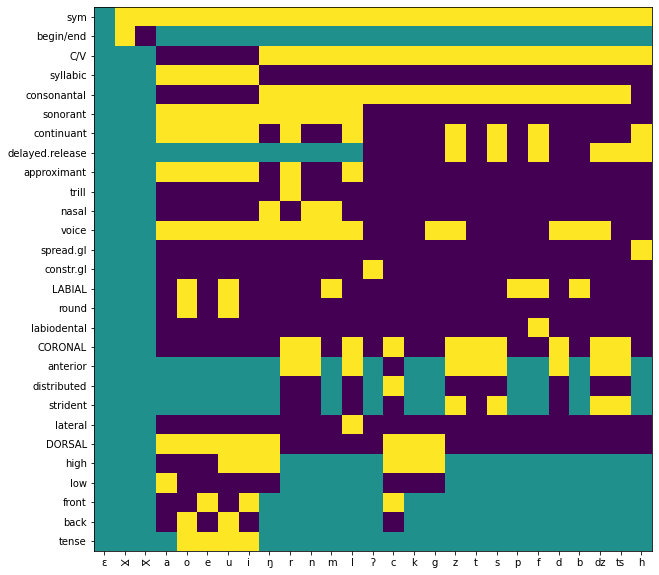

In [2]:
fig,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(config.F, aspect='auto')
ax.set_xticks(list(range(len(config.syms))))
ax.set_xticklabels(config.syms)
ax.set_yticks(list(range(len(config.ftrs))))
ax.set_yticklabels(config.ftrs)
plt.show()

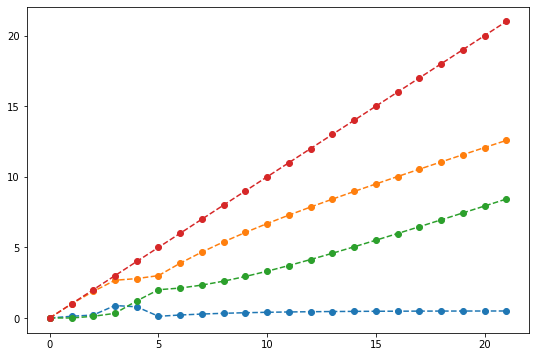

In [3]:
# # # # # # # # # #
# Recurrent update of scalar indices for decoding
nbatch = 1 # technical: include batch index
nrole = config.nrole
p = -1.0*torch.ones((nbatch, nrole)) # pivot signal
u = -1.0*torch.ones((nbatch, nrole)) # unpivot signal
p.data[0,2] = 1.0 # pivot from stem to affix at decode step 2
u.data[0,4] = 1.0 # unpivot from affix to stem at decode step 4

tau = 2.0 # precision of pivot/unpivot
a = torch.zeros((nbatch, nrole)) # morph index
b0 = torch.zeros((nbatch, nrole)) # position in stem
b1 = torch.zeros((nbatch, nrole)) # position in affix
c = torch.zeros((nbatch, nrole)) # position in output
# xxx implement deletion (write epsilon, do not advance in output)
for i in range(nrole-1):
    a[:,i+1] = a[:,i] + \
        (1.0-a[:,i]) * sigmoid(tau*p[:,i]) - a[:,i] * sigmoid(tau*u[:,i])
    b0[:,i+1] = b0[:,i] + (1.0-a[:,i]) * 1.0
    b1[:,i+1] = b1[:,i] + a[:,i] * 1.0
    c[:,i+1] = c[:,i] + 1.0

fig,ax = plt.subplots(1, figsize=(9,6))
for x in [a, b0, b1, c]:
    ax.plot(x[0], 'o--')
plt.show()

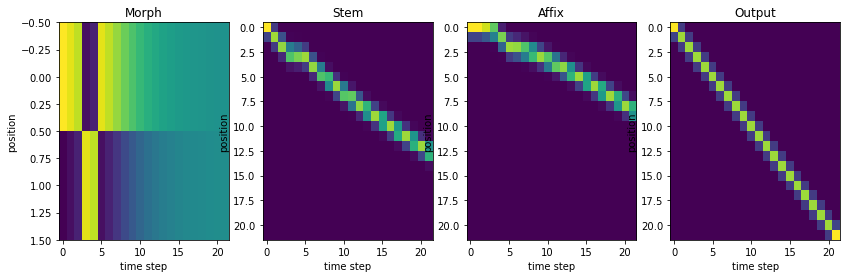

In [4]:
# # # # # # # # # #
# Map scalar positions to attention distributions using Softmax-RBF
morph_attender = GaussianPool(2, tau=1.0)
posn_attender = GaussianPool(nrole, tau=1.0)
alpha = torch.zeros((nbatch, nrole, 2))
beta0 = torch.zeros((nbatch, nrole, nrole))
beta1 = torch.zeros((nbatch, nrole, nrole))
omega = torch.zeros((nbatch, nrole, nrole))
for i in range(nrole):
    alpha[:,i] = morph_attender(a[:,i].unsqueeze(-1))
    beta0[:,i] = posn_attender(b0[:,i].unsqueeze(-1))
    beta1[:,i] = posn_attender(b1[:,i].unsqueeze(-1))
    omega[:,i] = posn_attender(c[:,i].unsqueeze(-1))

fig,ax = plt.subplots(1, 4, figsize=(14,4))
titles = ('Morph', 'Stem', 'Affix', 'Output')
for i,x in enumerate([alpha, beta0, beta1, omega]):
    ax[i].imshow(x[0].detach().T, origin='upper', aspect='auto')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('time step')
    ax[i].set_ylabel('position')

⋊ t i b a l e ⋉


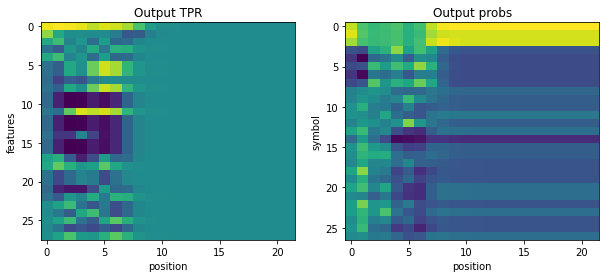

In [5]:
# # # # # # # # # #
# Decode output
Stem = config.form_embedder.string2tpr('t i l e').unsqueeze(0)
Affix = config.form_embedder.string2tpr('b a', delim=False).unsqueeze(0)
Output = torch.zeros_like(Stem)

# batch matrix-vector multiplication
def bmatvec(M, v):
    x = M * v.unsqueeze(1)
    x = torch.sum(x,-1)
    return x

for i in range(nrole):
    xi = alpha[:,i,0] * bmatvec(Stem, beta0[:,i]) \
        + alpha[:,i,1] * bmatvec(Affix, beta1[:,i])
    ri = bmatvec(config.R, omega[:,i]) # identity map with localist roles
    Output = Output + xi.t() @ ri

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(Output.detach()[0], origin='upper', aspect='auto')
ax[0].set_xlabel('position')
ax[0].set_ylabel('features')
ax[0].set_title('Output TPR')

output = decoder(Output)
ax[1].imshow(output.detach()[0], origin='upper', aspect='auto')
ax[1].set_xlabel('position')
ax[1].set_ylabel('symbol')
ax[1].set_title('Output probs')

output_seg = decoder.decode(Output)
output_seg = config.form_embedder.idvec2string(output_seg[0], trim=True)
print(output_seg)

In [15]:
x = torch.mean(config.F, 1)
print(x)

tensor([ 0.9630,  0.0000,  0.5185, -0.5185,  0.4444, -0.1481, -0.0741, -0.0741,
        -0.3704, -0.8148, -0.6667,  0.2222, -0.8148, -0.8148, -0.4444, -0.7407,
        -0.8148, -0.1481,  0.2963, -0.2963, -0.0741, -0.8148, -0.2222,  0.1111,
        -0.2593,  0.0000, -0.0741,  0.1481])


In [16]:
x = torch.arange(10).unsqueeze(1)
y = torch.arange(5)
print(x.shape, y.shape)
x - y

torch.Size([10, 1]) torch.Size([5])


tensor([[ 0, -1, -2, -3, -4],
        [ 1,  0, -1, -2, -3],
        [ 2,  1,  0, -1, -2],
        [ 3,  2,  1,  0, -1],
        [ 4,  3,  2,  1,  0],
        [ 5,  4,  3,  2,  1],
        [ 6,  5,  4,  3,  2],
        [ 7,  6,  5,  4,  3],
        [ 8,  7,  6,  5,  4],
        [ 9,  8,  7,  6,  5]])